<a href="https://colab.research.google.com/github/JPacolla376/Data-mining/blob/main/Tarefa_extra_Maikon_Gino_Jo%C3%A3o_Augusto_Pacolla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests beautifulsoup4 pandas matplotlib seaborn -q

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.ticker import FuncFormatter

In [ ]:
#ETAPA 2
print("=== Início do script ===")


url = 'https://pt.wikipedia.org/wiki/Lista_de_pa%C3%ADses_por_popula%C3%A7%C3%A3o'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
}

resp = requests.get(url, headers=headers)
resp.raise_for_status()
soup = BeautifulSoup(resp.content, 'html.parser')

tabelas = soup.find_all('table', {'class': 'wikitable'})

tabela_selecionada = None
motivo = ""
for t in tabelas:

    first_tr = t.find('tr')
    if first_tr:
        ths = [th.get_text(" ", strip=True) for th in first_tr.find_all('th')]
        header_text = " | ".join(ths).lower()

        if 'estimativa' in header_text and ('país' in header_text or 'território' in header_text):
            tabela_selecionada = t
            motivo = "Cabeçalho contém 'estimativa' e 'país/território'."
            break


if tabela_selecionada is None and tabelas:
    tabela_selecionada = tabelas[0]
    motivo = "Nenhuma tabela com 'estimativa' encontrada — usando a primeira 'wikitable' como fallback."

if tabela_selecionada is None:
    raise RuntimeError("Nenhuma tabela 'wikitable' encontrada na página.")

print("Tabela selecionada. Motivo:", motivo)


=== Início do script ===
Tabela selecionada. Motivo: Cabeçalho contém 'estimativa' e 'país/território'.


In [ ]:
#ETAPA 3
cabecalho_tr = tabela_selecionada.find('tr')
if cabecalho_tr:
    headers_list = [th.get_text(" ", strip=True) for th in cabecalho_tr.find_all('th')]
else:
    headers_list = []

if headers_list:
    for i, h in enumerate(headers_list):
        print(f"  {i}: {h}")
else:
    print("Atenção: nenhum cabeçalho com <th> detectado na primeira linha da tabela.")

linhas = []
for tr in tabela_selecionada.find_all('tr')[1:]:
    tds = tr.find_all(['td', 'th'])
    if not tds:
        continue
    celulas = [td.get_text(" ", strip=True) for td in tds]
    if len(celulas) == 0:
        continue
    linhas.append(celulas)

print(f"Linhas extraídas: {len(linhas)}")

df_raw = pd.DataFrame(linhas)
print("DataFrame bruto criado com shape:", df_raw.shape)

col_pais_idx = None
col_pop_idx = None

headers_norm = [h.lower() for h in headers_list] if headers_list else []

if headers_norm:
    for i, h in enumerate(headers_norm):
        if col_pais_idx is None and ('país' in h or 'território' in h or 'país ou território' in h):
            col_pais_idx = i
    for i, h in enumerate(headers_norm):
        if col_pop_idx is None and ('estimativa' in h and '2023' in h):
            col_pop_idx = i
    if col_pop_idx is None:
        for i, h in enumerate(headers_norm):
            if col_pop_idx is None and ('estimativa' in h or 'população' in h or 'population' in h):
                col_pop_idx = i

print("Índices tentados via cabeçalho:", "pais =", col_pais_idx, ", pop =", col_pop_idx)

if col_pais_idx is None or col_pop_idx is None:
    alphabetic_scores = []
    numeric_scores = []
    for c in df_raw.columns:
        series = df_raw[c].astype(str)
        alpha_count = series.str.contains(r'[A-Za-zÀ-ÿ]', regex=True).sum()
        digit_count = series.str.contains(r'\d', regex=True).sum()
        alphabetic_scores.append(alpha_count)
        numeric_scores.append(digit_count)
    col_pais_idx = int(pd.Series(alphabetic_scores).idxmax())
    col_pop_idx = int(pd.Series(numeric_scores).idxmax())
    if col_pop_idx == col_pais_idx:
        col_pop_idx = int(pd.Series(numeric_scores).nlargest(2).index[-1])
    print("Fallback índices:", "pais =", col_pais_idx, ", pop =", col_pop_idx)

ncols = df_raw.shape[1]
if col_pais_idx is None or col_pop_idx is None:
    raise RuntimeError("Não foi possível identificar índices de país/população.")
if col_pais_idx >= ncols or col_pop_idx >= ncols:
    raise RuntimeError(f"Índices detectados inválidos (ncols={ncols}): pais={col_pais_idx}, pop={col_pop_idx}")

print(f"Índices finais: país = {col_pais_idx}, população = {col_pop_idx}")

df = df_raw.iloc[:, [col_pais_idx, col_pop_idx]].copy()
df.columns = ['Pais_raw', 'Pop_raw']

df['Pais'] = df['Pais_raw'].str.replace(r'\[.*?\]', '', regex=True).str.strip()
df['Pais'] = df['Pais'].str.replace(r'^\d+\s*', '', regex=True).str.strip()

def extrai_numero_pop(s):
    if pd.isna(s):
        return None
    s = str(s)
    s = re.sub(r'\[.*?\]', '', s)
    s = re.sub(r'\(.*?\)', '', s)
    m = re.search(r'[\d][\d\.\,\s]*', s)
    if not m:
        return None
    num_text = m.group(0)
    num_only = re.sub(r'[^\d]', '', num_text)
    if num_only == '':
        return None
    try:
        return int(num_only)
    except:
        return None

df['Populacao'] = df['Pop_raw'].apply(extrai_numero_pop)
df = df.dropna(subset=['Populacao']).copy()
df['Populacao'] = df['Populacao'].astype(int)
df = df[~df['Pais'].str.lower().str.contains(r'mundo|total|região|área', regex=True)].copy()
df = df[['Pais', 'Populacao']].sort_values(by='Populacao', ascending=False).reset_index(drop=True)

print("Limpeza concluída. Exemplo das primeiras linhas:")
print(df.head(10).to_string(index=False))


  0: 
  1: Posição
  2: País (ou território dependente)
  3: Estimativa da ONU
  4: Crescimento desde a última estimativa
  5: Estimativa Oficial
Linhas extraídas: 250
DataFrame bruto criado com shape: (250, 6)
Índices tentados via cabeçalho: pais = 2 , pop = 3
Índices finais: país = 2, população = 3
Limpeza concluída. Exemplo das primeiras linhas:
          Pais  Populacao
         Índia 1417492000
         China 1407934000
Estados Unidos  342181000
     Indonésia  285783000
     Paquistão  256204000
       Nigéria  236213000
        Brasil  214244000
    Bangladesh  177567000
        Rússia  146022000
        México  131013000


Validações antes de plotar:
Shape do df: (250, 2)
Top 5 países por população (verificação):
          Pais  Populacao
         Índia 1417492000
         China 1407934000
Estados Unidos  342181000
     Indonésia  285783000
     Paquistão  256204000

Bottom 5 (verificação):
                               Pais  Populacao
   Ilha de Ascensão ( Reino Unido )       1100
                           Vaticano        879
Ilhas Cocos (Keeling) ( Austrália )        605
   Tristão da Cunha ( Reino Unido )        264
     Ilhas Pitcairn ( Reino Unido )         67

Mediana (população): 4.826.000
Máxima (população): 1.417.492.000
Mínima (população): 67


/tmp/ipython-input-1543121364.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Populacao', y='Pais', data=df_top15, palette='viridis')


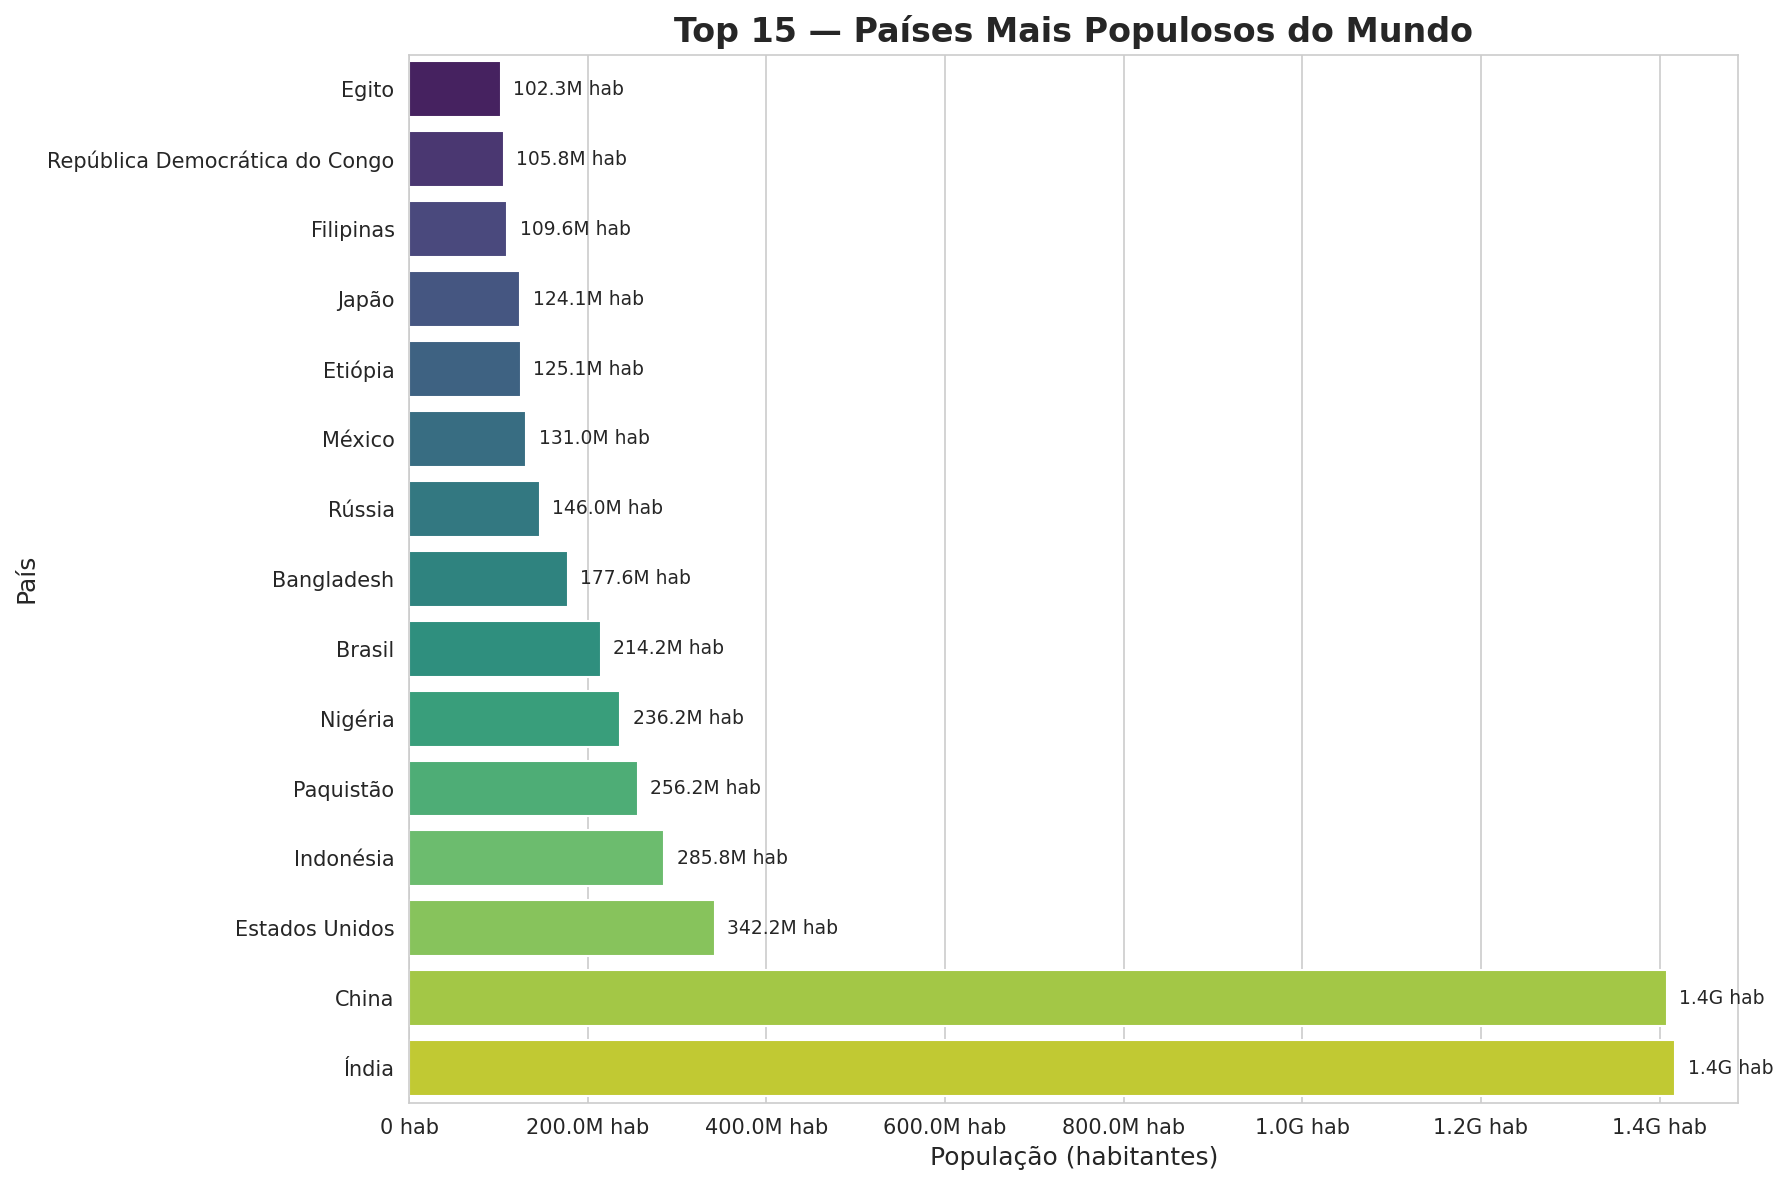

Figura salva: /mnt/data/figuras_etapa4/top15_populosos.png


/tmp/ipython-input-1543121364.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Populacao', y='Pais', data=df_bottom15, palette='mako')


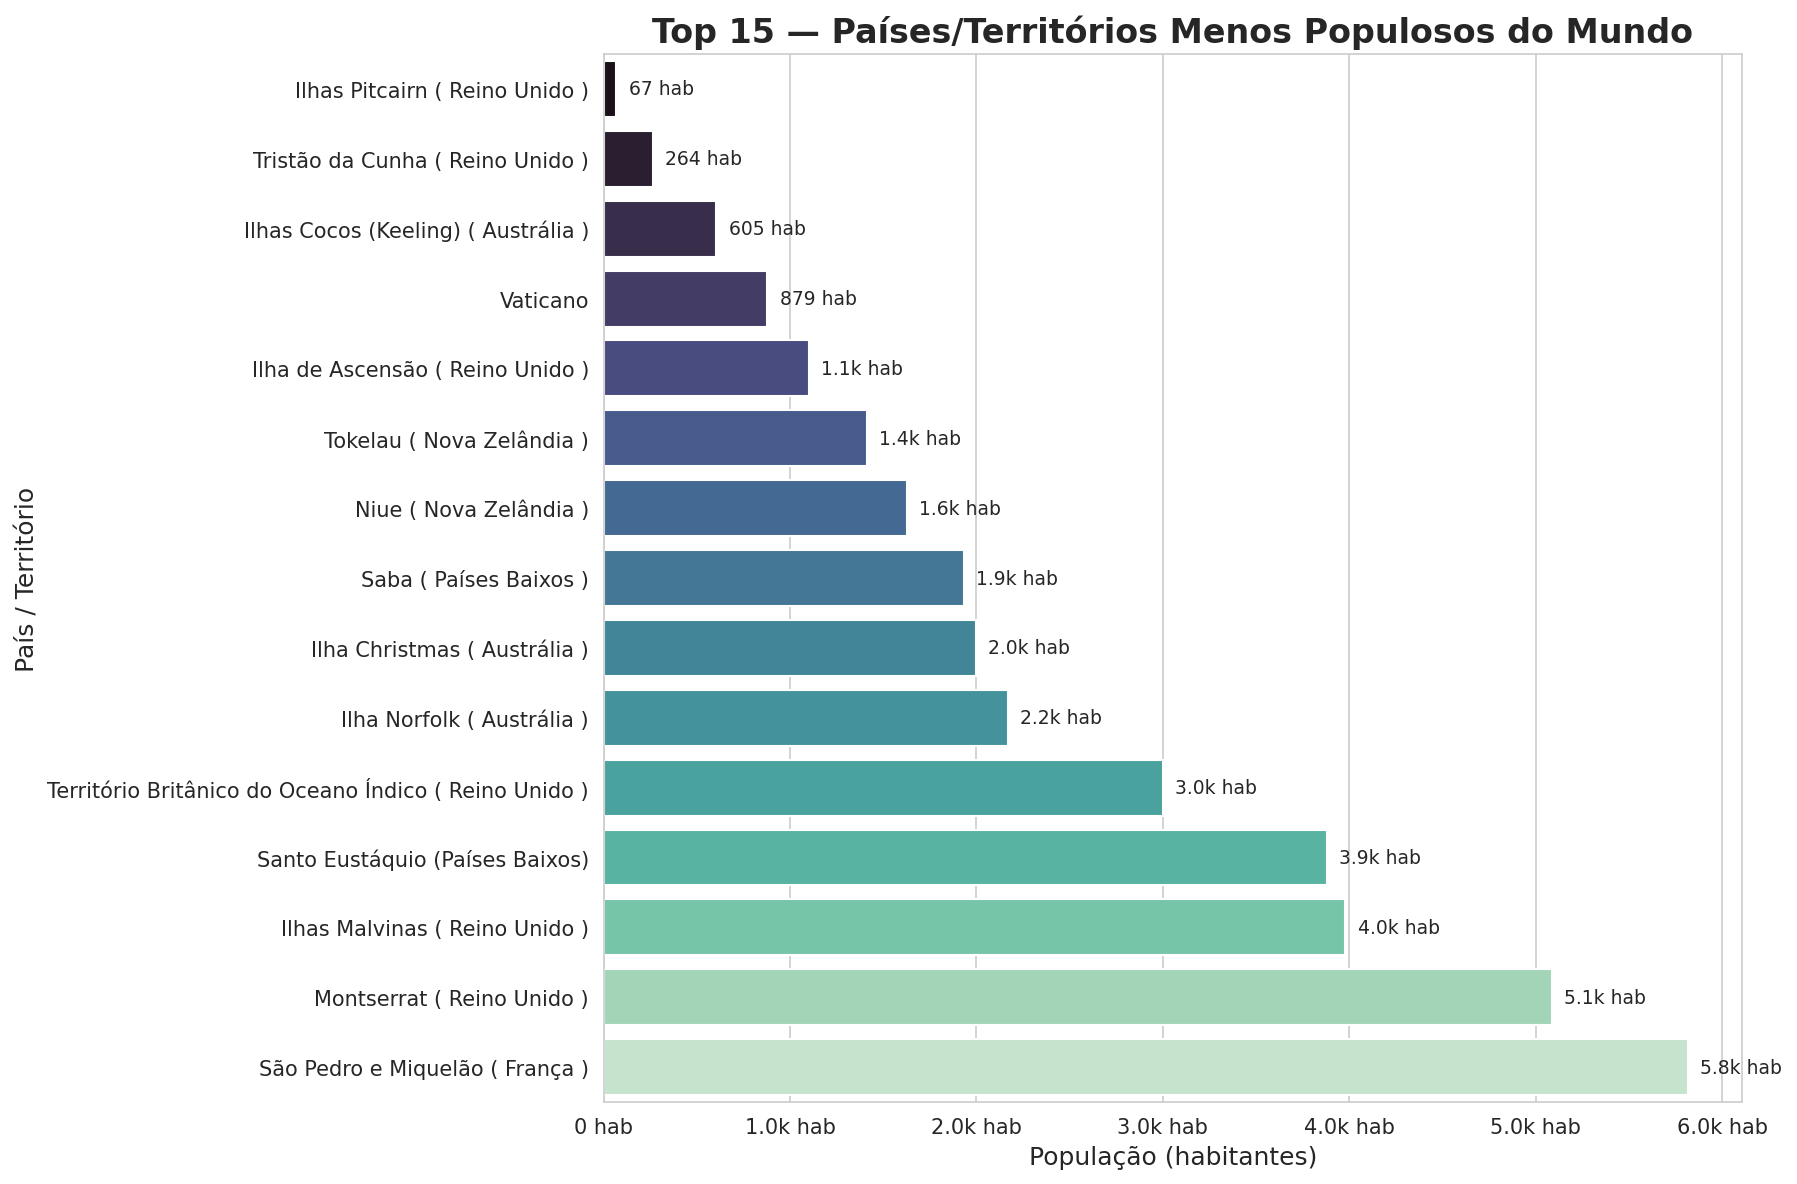

Figura salva: /mnt/data/figuras_etapa4/bottom15_menos_populosos.png


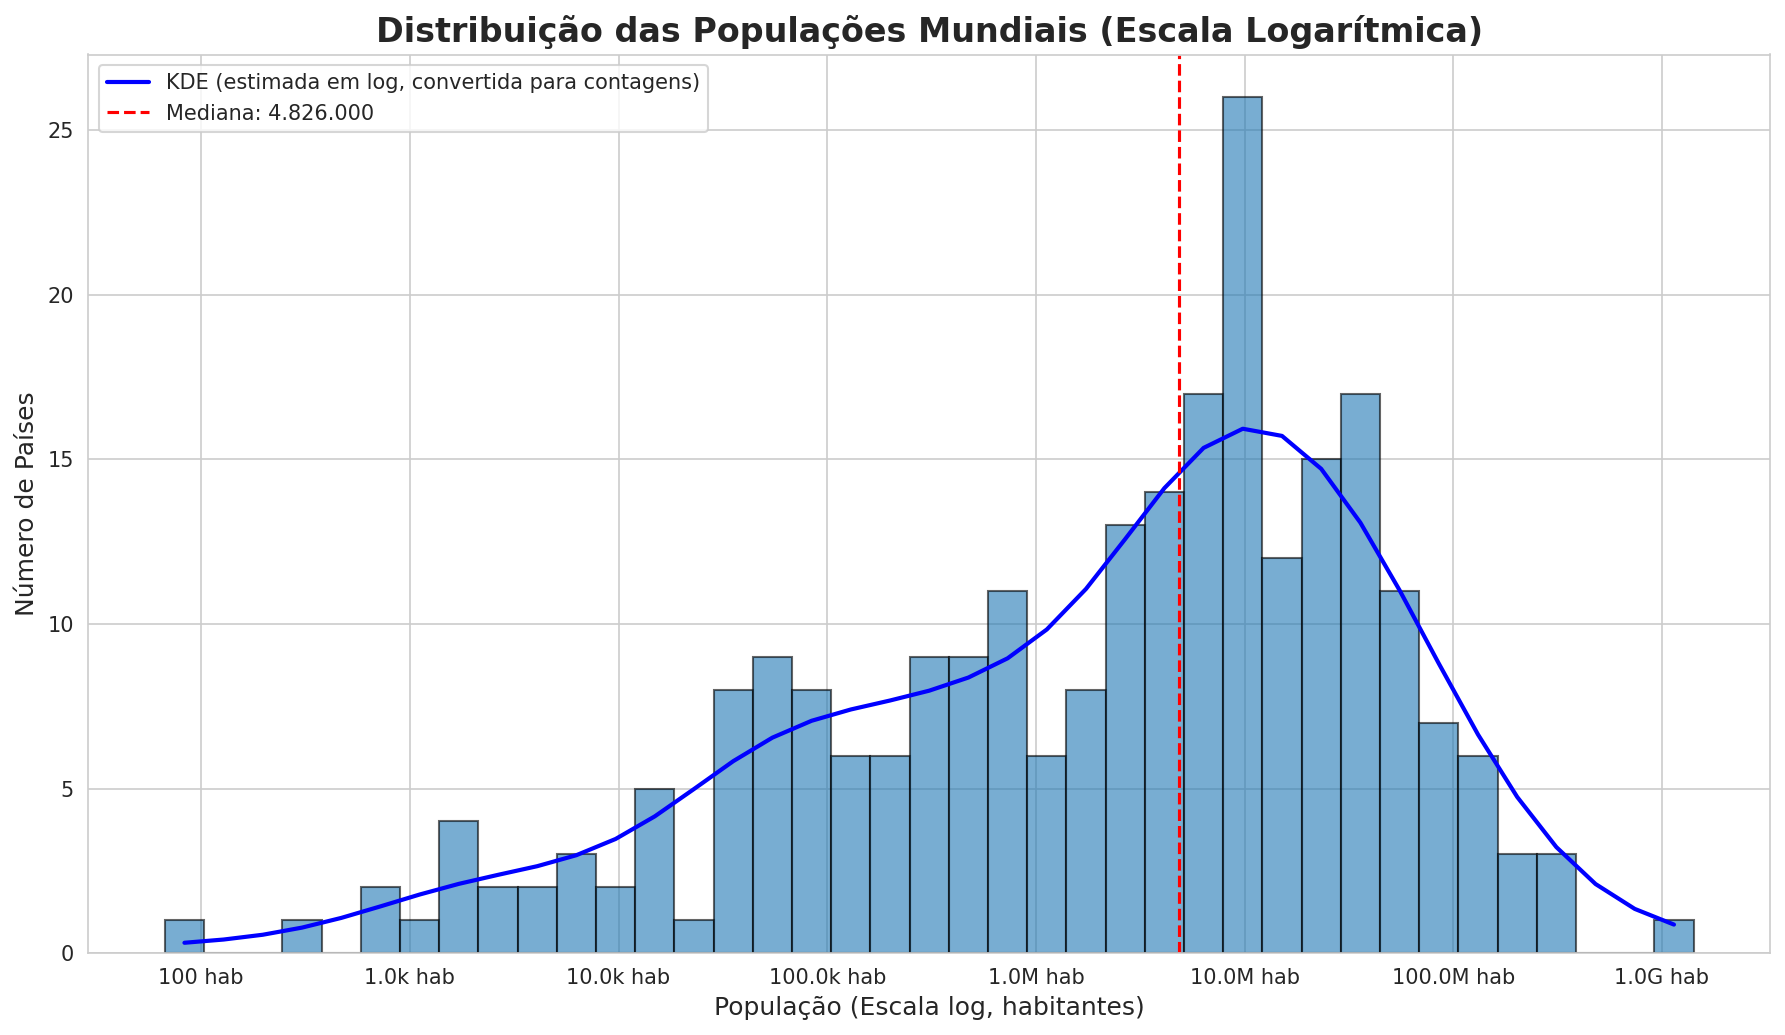

Figura salva: /mnt/data/figuras_etapa4/histograma_pop_log.png

Resumo final (verifique os arquivos gerados):
 - Top 15 salvo em: /mnt/data/figuras_etapa4/top15_populosos.png
 - Bottom 15 salvo em: /mnt/data/figuras_etapa4/bottom15_menos_populosos.png
 - Histograma (log) salvo em: /mnt/data/figuras_etapa4/histograma_pop_log.png

Exemplo — Top 15 (tabela):
                          Pais  Populacao
                         Índia 1417492000
                         China 1407934000
                Estados Unidos  342181000
                     Indonésia  285783000
                     Paquistão  256204000
                       Nigéria  236213000
                        Brasil  214244000
                    Bangladesh  177567000
                        Rússia  146022000
                        México  131013000
                       Etiópia  125092825
                         Japão  124127899
                     Filipinas  109581078
República Democrática do Congo  105823799
             

In [ ]:
#ETAPA 4
# ETAPA 4 (corrigida: histograma/log com KDE corretamente escalada para contagens)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
from scipy.stats import gaussian_kde
import math

out_dir = "/mnt/data/figuras_etapa4"
os.makedirs(out_dir, exist_ok=True)

def formato_compacto_hab(x, pos=None):
    try:
        x = float(x)
    except Exception:
        return ""
    if x >= 1e9:
        return f'{x/1e9:.1f}G hab'
    if x >= 1e6:
        return f'{x/1e6:.1f}M hab'
    if x >= 1e3:
        return f'{x/1e3:.1f}k hab'
    return f'{int(x):,} hab'.replace(',', '.')

sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

print("Validações antes de plotar:")
print("Shape do df:", df.shape)
print("Top 5 países por população (verificação):")
print(df.head(5).to_string(index=False))
print("\nBottom 5 (verificação):")
print(df.tail(5).to_string(index=False))

mediana_pop = int(df['Populacao'].median())
max_pop = int(df['Populacao'].max())
min_pop = int(df['Populacao'].min())
print(f"\nMediana (população): {mediana_pop:,}".replace(',', '.'))
print(f"Máxima (população): {max_pop:,}".replace(',', '.'))
print(f"Mínima (população): {min_pop:,}".replace(',', '.'))

if max_pop < 1_000_000_000:
    print("ATENÇÃO: valor máximo de população < 1 bilhão — verifique se houve erro na raspagem.")
if df.head(3)['Pais'].str.lower().isin(['china', 'índia', 'estados unidos', 'estados unidos da américa']).sum() < 1:
    print("ATENÇÃO: top 3 não contém China/Índia/EUA — confirme se o DataFrame está correto.")

# -------------------------
# Visualização 1: Top 15
# -------------------------
df_top15 = df.head(15).copy()
df_top15 = df_top15.sort_values(by='Populacao', ascending=True)

plt.figure(figsize=(12, 8))
ax1 = sns.barplot(x='Populacao', y='Pais', data=df_top15, palette='viridis')
ax1.set_title('Top 15 — Países Mais Populosos do Mundo', fontsize=16, weight='bold')
ax1.set_xlabel('População (habitantes)', fontsize=12)
ax1.set_ylabel('País', fontsize=12)
ax1.xaxis.set_major_formatter(FuncFormatter(formato_compacto_hab))

for p in ax1.patches:
    w = int(p.get_width())
    ax1.annotate(f'{formato_compacto_hab(w)}',
                 (w, p.get_y() + p.get_height()/2),
                 xytext=(6, 0), textcoords='offset points',
                 va='center', fontsize=9)

plt.tight_layout()
fn1 = os.path.join(out_dir, "top15_populosos.png")
plt.savefig(fn1, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figura salva: {fn1}")

# -------------------------
# Visualização 2: Bottom 15
# -------------------------
df_bottom15 = df.tail(15).sort_values(by='Populacao', ascending=True).copy()

plt.figure(figsize=(12, 8))
ax2 = sns.barplot(x='Populacao', y='Pais', data=df_bottom15, palette='mako')
ax2.set_title('Top 15 — Países/Territórios Menos Populosos do Mundo', fontsize=16, weight='bold')
ax2.set_xlabel('População (habitantes)', fontsize=12)
ax2.set_ylabel('País / Território', fontsize=12)
ax2.xaxis.set_major_formatter(FuncFormatter(formato_compacto_hab))

for p in ax2.patches:
    w = int(p.get_width())
    ax2.annotate(f'{formato_compacto_hab(w)}',
                 (w, p.get_y() + p.get_height()/2),
                 xytext=(6, 0), textcoords='offset points',
                 va='center', fontsize=9)

plt.tight_layout()
fn2 = os.path.join(out_dir, "bottom15_menos_populosos.png")
plt.savefig(fn2, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figura salva: {fn2}")

# -------------------------
# Visualização 3: Histograma (Bins logarítmicos) + KDE (estimada em log) + Mediana
# -------------------------
pop = df['Populacao'].values
N = pop.size
bins_log = np.logspace(np.log10(pop.min()), np.log10(pop.max()), 40)

fig, ax3 = plt.subplots(figsize=(12, 7))
# histograma com contagens (counts)
counts, edges, patches = ax3.hist(pop, bins=bins_log, density=False, alpha=0.6, edgecolor='k')

# KDE estimada no espaço log10(pop), depois transformada para o espaço original
logpop = np.log10(pop)
kde = gaussian_kde(logpop)
xlog = np.linspace(logpop.min(), logpop.max(), 1000)
ylog = kde(xlog)  # densidade em espaço log10
x = 10 ** xlog
# transformação da densidade: f_X(x) = f_log(log10 x) * (1 / (x * ln(10)))
fx = ylog / (x * math.log(10))

# converter pdf (fx) para estimativa de contagens por bin:
# counts_est_bin = fx(bin_center) * N * bin_width
bin_centers = np.sqrt(edges[:-1] * edges[1:])  # geometric mean é mais apropriado para log bins
bin_widths = edges[1:] - edges[:-1]
# avaliar fx nos bin_centers (interpolando a partir de x, fx)
fx_at_centers = np.interp(np.log10(bin_centers), xlog, ylog) / (bin_centers * math.log(10))
counts_fit = fx_at_centers * N * bin_widths

# plotar histograma (já feito) e sobrepor a curva estimada de contagens
ax3.plot(bin_centers, counts_fit, color='blue', linewidth=2, label='KDE (estimada em log, convertida para contagens)')

ax3.set_xscale('log')
ax3.set_title('Distribuição das Populações Mundiais (Escala Logarítmica)', fontsize=16, weight='bold')
ax3.set_xlabel('População (Escala log, habitantes)', fontsize=12)
ax3.set_ylabel('Número de Países', fontsize=12)

ax3.axvline(mediana_pop, color='red', linestyle='--', linewidth=1.5, label=f'Mediana: {mediana_pop:,}'.replace(',', '.'))

ax3.xaxis.set_major_formatter(FuncFormatter(formato_compacto_hab))
ax3.set_xticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9])
ax3.get_xaxis().set_tick_params(rotation=0)

plt.legend()
plt.tight_layout()
fn3 = os.path.join(out_dir, "histograma_pop_log.png")
plt.savefig(fn3, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figura salva: {fn3}")

# -------------------------
# Saída adicional (arquivos e resumo)
# -------------------------
print("\nResumo final (verifique os arquivos gerados):")
print(" - Top 15 salvo em:", fn1)
print(" - Bottom 15 salvo em:", fn2)
print(" - Histograma (log) salvo em:", fn3)
print("\nExemplo — Top 15 (tabela):")
print(df_top15.sort_values('Populacao', ascending=False).to_string(index=False))
